In [1]:
# Cargando librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

In [2]:
# Cargando y explorando dataset
data = pd.read_csv('Customer Churn.csv')

print("Dimensiones del dataset:", data.shape)
print(data.head())
print(data.info())

Dimensiones del dataset: (3150, 14)
   Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0              8          0                    38               0   
1              0          0                    39               0   
2             10          0                    37               0   
3             10          0                    38               0   
4              3          0                    38               0   

   Seconds of Use  Frequency of use  Frequency of SMS  \
0            4370                71                 5   
1             318                 5                 7   
2            2453                60               359   
3            4198                66                 1   
4            2393                58                 2   

   Distinct Called Numbers  Age Group  Tariff Plan  Status  Age  \
0                       17          3            1       1   30   
1                        4          2            1       2   25   
2    

In [3]:
# Normalizando los nombres de columnas (elimina espacios extra)
data.columns = data.columns.str.strip().str.replace(' +', ' ', regex=True)

# Verificando nombres corregidos
print("Columnas del dataset:")
print(data.columns.tolist())

Columnas del dataset:
['Call Failure', 'Complains', 'Subscription Length', 'Charge Amount', 'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age', 'Customer Value', 'Churn']


In [4]:
# Separando variables
X = data.drop('Churn', axis=1)
y = data['Churn']

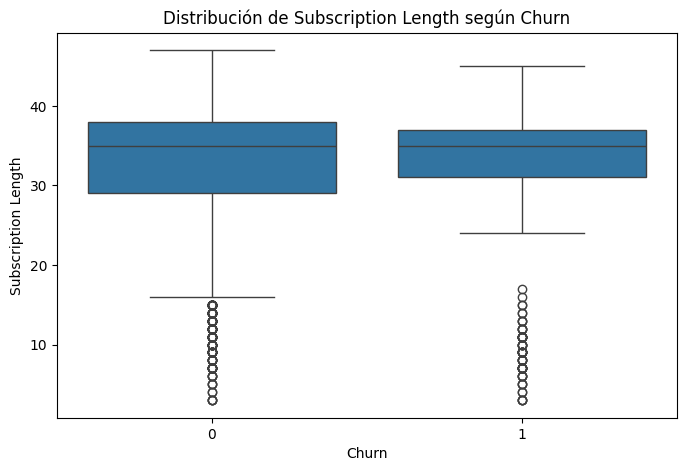

        count       mean       std  min   25%   50%   75%   max
Churn                                                          
0      2655.0  32.662524  8.392357  3.0  29.0  35.0  38.0  47.0
1       495.0  31.894949  9.469163  3.0  31.0  35.0  37.0  45.0


In [5]:
# Analizando variable Subscription Length
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='Subscription Length', data=data)
plt.title('Distribución de Subscription Length según Churn')
plt.show()

print(data.groupby('Churn')['Subscription Length'].describe())

In [6]:
# Estandarizando variables regresoras
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [7]:
# Balanceando clases con SMOTE
print("Distribución original de clases:")
print(y.value_counts())

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

print("\nDistribución balanceada de clases:")
print(pd.Series(y_res).value_counts())

Distribución original de clases:
Churn
0    2655
1     495
Name: count, dtype: int64

Distribución balanceada de clases:
Churn
0    2655
1    2655
Name: count, dtype: int64


In [8]:
# Dividiendo en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=42, stratify=y_res)

In [9]:
# Modelando RANDOMFOREST utilizando hiperparametros por defecto
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("\nReporte de Clasificación RandomForest:")
print(classification_report(y_test, y_pred_rf))
f1_rf = f1_score(y_test, y_pred_rf)
print("F1-Score promedio:", round(f1_rf, 3))


Reporte de Clasificación RandomForest:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       877
           1       0.96      0.99      0.98       876

    accuracy                           0.97      1753
   macro avg       0.98      0.97      0.97      1753
weighted avg       0.98      0.97      0.97      1753

F1-Score promedio: 0.975



Las 7 características más importantes:
Status                     0.167736
Frequency of use           0.134686
Seconds of Use             0.114261
Complains                  0.112992
Subscription Length        0.108024
Customer Value             0.096618
Distinct Called Numbers    0.073424
dtype: float64


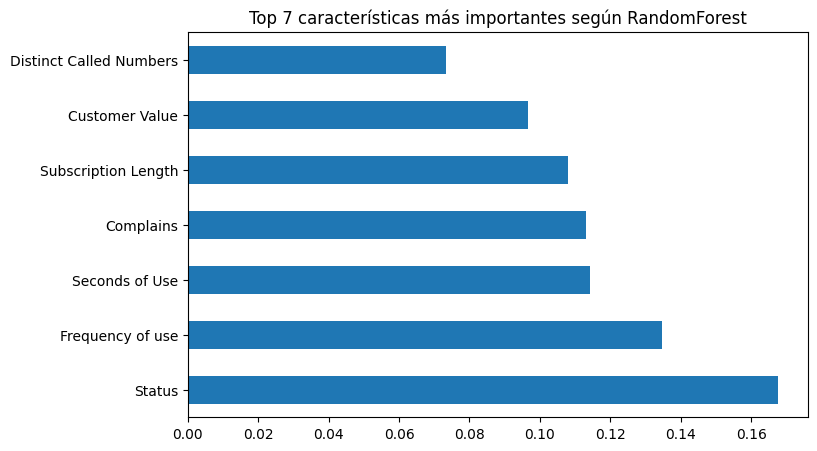

In [10]:
# Mostrando caracteristicas importantes
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top7_features = importances.head(7)
print("\nLas 7 características más importantes:")
print(top7_features)

plt.figure(figsize=(8,5))
top7_features.plot(kind='barh')
plt.title('Top 7 características más importantes según RandomForest')
plt.show()

In [11]:
# Filtrando las 7 caracteristicas más importantes
X_train_nn = X_train[top7_features.index]
X_test_nn = X_test[top7_features.index]

In [12]:
# Construyendo modelo de red neuronal feedforward
model = Sequential()
model.add(Dense(10, input_dim=7, activation='relu'))  # Capa oculta con 10 neuronas
model.add(Dense(1, activation='sigmoid'))  # Capa de salida binaria

C:\Users\daclv\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Compilando modelo
opt = SGD(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])

In [14]:
# Entrenando modelo
history = model.fit(X_train_nn, y_train, validation_data=(X_test_nn, y_test),epochs=100, batch_size=16, verbose=1)

Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5036 - loss: 0.7540 - val_AUC: 0.9100 - val_loss: 0.4845
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.9015 - loss: 0.4658 - val_AUC: 0.9260 - val_loss: 0.4068
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9261 - loss: 0.3976 - val_AUC: 0.9300 - val_loss: 0.3712
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9264 - loss: 0.3720 - val_AUC: 0.9305 - val_loss: 0.3518
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.9307 - loss: 0.3515 - val_AUC: 0.9309 - val_loss: 0.3406
Epoch 6/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9194 - loss: 0.3642 - val_AUC: 0.9310 - val_loss: 0.3337
Epoch 7/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.9181 - loss: 0.3597 - val_AUC: 0.9313 - val_loss: 0.3289
Epoch 8/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9288 - loss: 0.3320 - val_AUC: 0.9312 - val_loss: 0.3261
Epoch 9/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

In [15]:
# Evaluando modelo
y_pred_nn = model.predict(X_test_nn)
auc = roc_auc_score(y_test, y_pred_nn)

print("\nAUC del modelo de red neuronal:", round(auc, 3))

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

AUC del modelo de red neuronal: 0.955


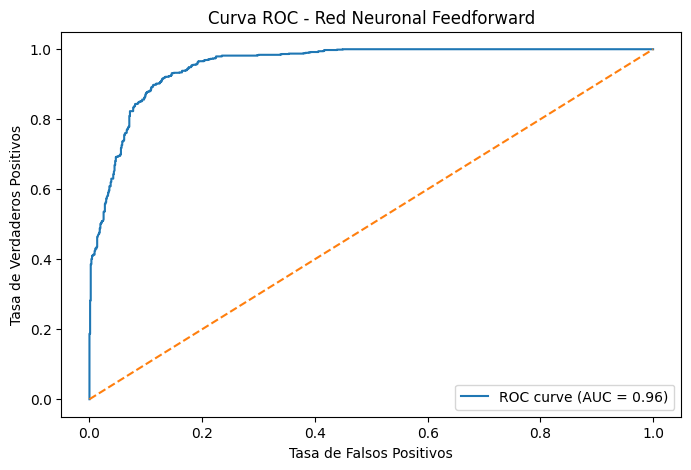

In [16]:
# Mostrando curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nn)
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Red Neuronal Feedforward')
plt.legend()
plt.show()

### Conclusion:

### De acuerdo al resultado obtenido, demostró que la red neuronal logró un nivel casi óptimo de clasificación interpretando correctamente la gran mayoría de los patrones que determinan la renuncia. 